In [1]:
import torch

In [23]:
import fishae
import fishvae

In [25]:
aeModel = torch.nn.DataParallel(fishae.FishAE())
aeModel.eval()
vaeModel = torch.nn.DataParallel(fishvae.FishVAE())
vaeModel.eval()

DataParallel(
  (module): FishVAE(
    (encoder): Encoder(
      (main): Sequential(
        (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): LeakyReLU(negative_slope=0.2, inplace=True)
        (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): LeakyReLU(negative_slope=0.2, inplace=True)
        (5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (7): LeakyReLU(negative_slope=0.2, inplace=True)
        (8): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (9): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (10): LeakyReLU(negative_slope=0.2, inplace=True)
        (11): Conv2d(1024, 2048,

In [3]:
MVTEC_ROOT_DIR = "/scratch/ssd002/datasets/MVTec_AD"

In [4]:
from vector_cv_tools import transforms as VT
import albumentations as A
from albumentations.pytorch import ToTensorV2
from vector_cv_tools import datasets as vdatasets

In [5]:
from tqdm.notebook import tqdm

In [6]:
basic_transform = VT.ComposeMVTecTransform([A.Resize(128, 128), A.ToFloat(max_value=255), ToTensorV2()])
test_dset = vdatasets.MVTec(MVTEC_ROOT_DIR, split="test", mask_only= True ,obj_types=["toothbrush"], transforms = basic_transform)
train_dset = vdatasets.MVTec(MVTEC_ROOT_DIR, split="train", transforms = basic_transform, obj_types=["toothbrush"])
other_dset = vdatasets.MVTec(MVTEC_ROOT_DIR, split="train", transforms = basic_transform)

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
def show_img_from_tensor(single_img):
    single_img = single_img.permute(1,2,0).cpu().numpy()
    plt.imshow(single_img)
    plt.axis("off")
    plt.show()

def evaluate_and_show(model, single_input):
    single_input = single_input.to("cuda")
    with torch.no_grad():
        recon, mu, logvar = model(single_input)
    loss = loss_fn(single_input, recon, mu , logvar)
    print("Loss is: ", loss.item())
    show_img_from_tensor(recon.squeeze(0))

In [9]:
def show_imgs(*imgs):
    plt.rcParams["figure.figsize"] = (3*len(imgs),3)
    for i in range(len(imgs)):
        plt.subplot(1,len(imgs),i+1)
        single_img = imgs[i].permute(1,2,0).cpu().numpy()
        plt.imshow(single_img)
    plt.show()

In [58]:
def show_img_grid(imgs,
                  title=None,
                  xlabels=None,
                  ylabels=None,
                 ):

    
    plt.rcParams["figure.figsize"] = (3*len(imgs[0]),3*len(imgs))
    
    num_rows = len(imgs)
    num_cols = len(imgs[0])
    
    fig, axs = plt.subplots(num_rows,num_cols)#, constrained_layout=True)

    fig.patch.set_facecolor('white')
    
    if title: 
        fig.suptitle(title, fontsize=16)
    
    index = 1
    yind = 1
    for row in imgs:
        xind = 1
        for img in row:
            ax = plt.subplot(
                    num_rows,
                    num_cols,
                    index
            )
            index += 1
            single_img = img.permute(1,2,0).cpu().numpy()
            plt.imshow(single_img)
            
            # we don't really benefit from these numbers
            ax.set_yticklabels([])
            ax.set_xticklabels([])
            
            # labels if we have them
            if ylabels and xind == 1:
                ax.set_ylabel(ylabels[yind-1])
                
            if xlabels and yind == num_rows:
                ax.set_xlabel(xlabels[xind-1])
            
            xind+=1
        yind+=1
        
    plt.show()


In [18]:
def img2vec(model,img):
    imgpu = img.unsqueeze(0).to("cuda")
    with torch.no_grad():
        z = model.module.encoder(imgpu)
    return z[..., :100] # we only like mu
def vec2img(model,vec):
    with torch.no_grad():
        img = model.module.decoder(vec.unsqueeze(-1).unsqueeze(-1))
        img = img.squeeze(0)
    return img
def img2img(model,vec):
    return(vec2img(model,img2vec(model,vec)))

### Feel free to jump around from here

In [63]:
givenModel.load_state_dict(torch.load("/checkpoint/ttrim/fae_pt2/fishae_v1_lmda0.9_epo260.pt"))

<All keys matched successfully>

In [74]:
imgs = []
givenModel.eval()
givenModel.load_state_dict(torch.load("/checkpoint/ttrim/fae_pt2/fishae_v1_lmda0.0_epo260.pt"))
imgs+=[[other_dset[300][0], img2img(givenModel,other_dset[300][0])]]
givenModel.load_state_dict(torch.load("/checkpoint/ttrim/fae_pt2/fishae_v1_lmda0.5_epo260.pt"))
imgs+=[[other_dset[300][0], img2img(givenModel,other_dset[300][0])]]
givenModel.load_state_dict(torch.load("/checkpoint/ttrim/fae_pt2/fishae_v1_lmda0.9_epo260.pt"))
imgs+=[[other_dset[300][0], img2img(givenModel,other_dset[300][0])]]

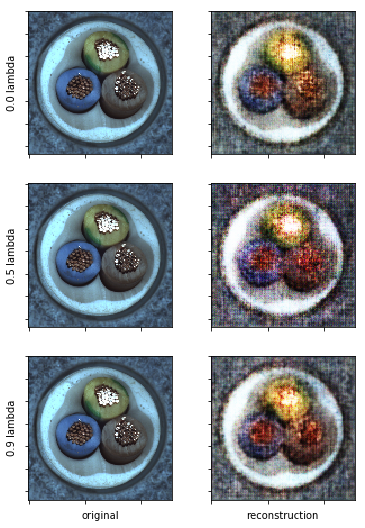

In [73]:
show_img_grid(imgs,
             xlabels=['original','reconstruction'],
             ylabels=['0.0 lambda','0.5 lambda','0.9 lambda'])

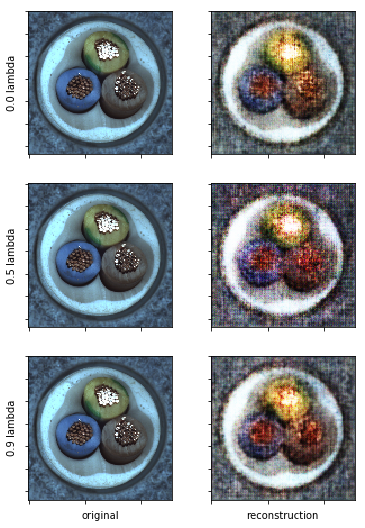

In [73]:
show_img_grid(imgs,
             xlabels=['original','reconstruction'],
             ylabels=['0.0 lambda','0.5 lambda','0.9 lambda'])

In [1]:
def loadmodel(given_filename):
    root = "/checkpoint/ttrim/"
    
    if "vae" in given_filename:
        subdir = ("fvae_pt1/",
                  "fvae_pt2/",
                 )
        print(f"loading {given_filename} as vae")
        
        for di in subdir:
            filename = root+di+given_filename
            try:
                vaeModel.load_state_dict(torch.load(filename))
                return vaeModel
            except FileNotFoundError:
                pass
        raise FileNotFoundError(f"couldn't find {filename}")
    else:
        subdir = ("fae_pt1/",
                  "fae_pt2/",
                 )
        print(f"loading {given_filename} as ae")
        
        for di in subdir:
            filename = root+di+given_filename
            try:
                aeModel.load_state_dict(torch.load(filename))
                return aeModel
            except FileNotFoundError:
                pass
        raise FileNotFoundError(f"couldn't find {filename}")
    

In [77]:
vaeModel.eval()
aeModel.eval()

DataParallel(
  (module): FishAE(
    (encoder): Encoder(
      (main): Sequential(
        (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): LeakyReLU(negative_slope=0.2, inplace=True)
        (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): LeakyReLU(negative_slope=0.2, inplace=True)
        (5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (7): LeakyReLU(negative_slope=0.2, inplace=True)
        (8): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (9): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (10): LeakyReLU(negative_slope=0.2, inplace=True)
        (11): Conv2d(1024, 2048, 

300
loading fishae_v1_lmda0.0_epo1.pt as ae
loading fishae_v1_lmda0.5_epo1.pt as ae
loading fishae_v1_lmda0.9_epo1.pt as ae
loading fishvae_v1_lmda0.0_epo1.pt as vae
loading fishvae_v1_lmda0.5_epo1.pt as vae
loading fishvae_v1_lmda0.9_epo1.pt as vae
300
loading fishae_v1_lmda0.0_epo2.pt as ae
loading fishae_v1_lmda0.5_epo2.pt as ae
loading fishae_v1_lmda0.9_epo2.pt as ae
loading fishvae_v1_lmda0.0_epo2.pt as vae
loading fishvae_v1_lmda0.5_epo2.pt as vae
loading fishvae_v1_lmda0.9_epo2.pt as vae
300
loading fishae_v1_lmda0.0_epo3.pt as ae
loading fishae_v1_lmda0.5_epo3.pt as ae
loading fishae_v1_lmda0.9_epo3.pt as ae
loading fishvae_v1_lmda0.0_epo3.pt as vae
loading fishvae_v1_lmda0.5_epo3.pt as vae
loading fishvae_v1_lmda0.9_epo3.pt as vae
300
loading fishae_v1_lmda0.0_epo5.pt as ae
loading fishae_v1_lmda0.5_epo5.pt as ae
loading fishae_v1_lmda0.9_epo5.pt as ae
loading fishvae_v1_lmda0.0_epo5.pt as vae
loading fishvae_v1_lmda0.5_epo5.pt as vae
loading fishvae_v1_lmda0.9_epo5.pt as vae


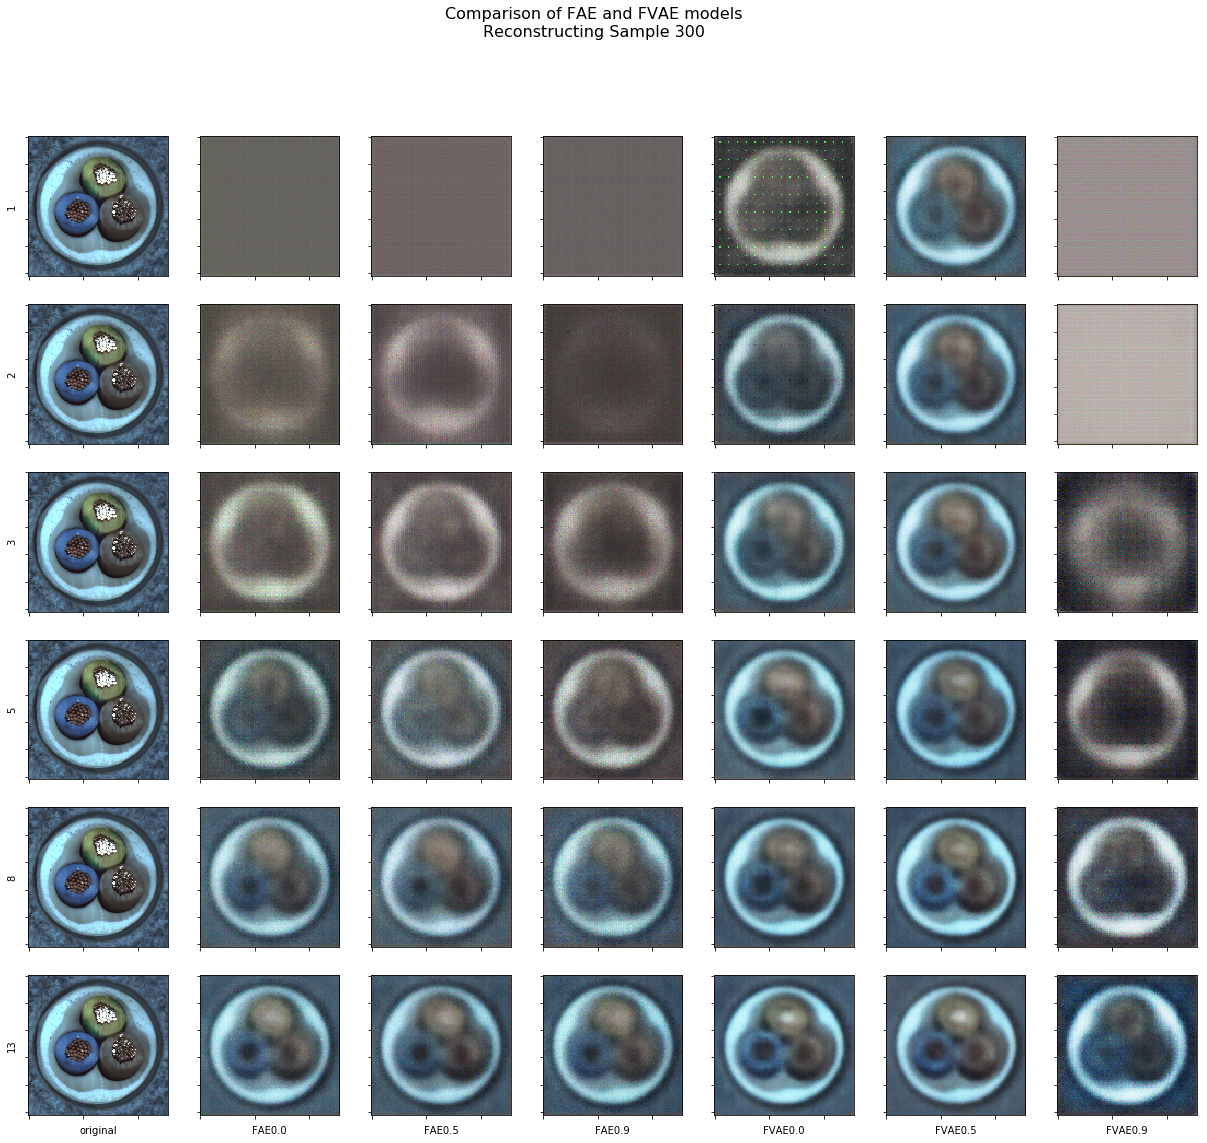

In [78]:
imgs = []
samplenum = 300
#epochs = ("3","13","100","500")
epochs = ("1","2","3","5","8","13")
#epochs = ("260",)
for epoch in epochs:

    model_files = (
        f"fishae_v1_lmda0.0_epo{epoch}.pt",
        f"fishae_v1_lmda0.5_epo{epoch}.pt",
        f"fishae_v1_lmda0.9_epo{epoch}.pt",

        f"fishvae_v1_lmda0.0_epo{epoch}.pt",
        f"fishvae_v1_lmda0.5_epo{epoch}.pt",
        f"fishvae_v1_lmda0.9_epo{epoch}.pt",
    )

    model_names = [
        "FAE0.0",
        "FAE0.5",
        "FAE0.9",
        "FVAE0.0",
        "FVAE0.5",
        "FVAE0.9",
    ]


    print(i)
    imgs += [[other_dset[samplenum][0]]]
    for j in range(len(model_files)):
        model = loadmodel(model_files[j])
        imgs[-1]+=[img2img(model,other_dset[samplenum][0])]

show_img_grid(imgs,
                 title=f"Comparison of FAE and FVAE models\nReconstructing Sample {samplenum}",
                 xlabels=['original',]+model_names,
                 ylabels=epochs
                     )

In [60]:
#fishmodel.load_state_dict(torch.load("/checkpoint/ttrim/fae/fishae_v1_lmda0.0_epo260.pt"))
fishmodel.load_state_dict(torch.load("/checkpoint/ttrim/fae/fishae_v1_lmda0.5_epo260.pt"))
#fishmodel.load_state_dict(torch.load("/checkpoint/ttrim/fae/fishae_v1_lmda0.9_epo260.pt"))

prev_img = other_dset[300][0]
imgs = [[],[],[]]
for i in tqdm(range(0,1000)):
    if i < 10:
        imgs[0]+=[prev_img]
    if i%10==0 and i< 100:
        imgs[1]+=[prev_img]
    if i%100==0:
        imgs[2]+=[prev_img]
    prev_img = vec2img(img2vec(prev_img))



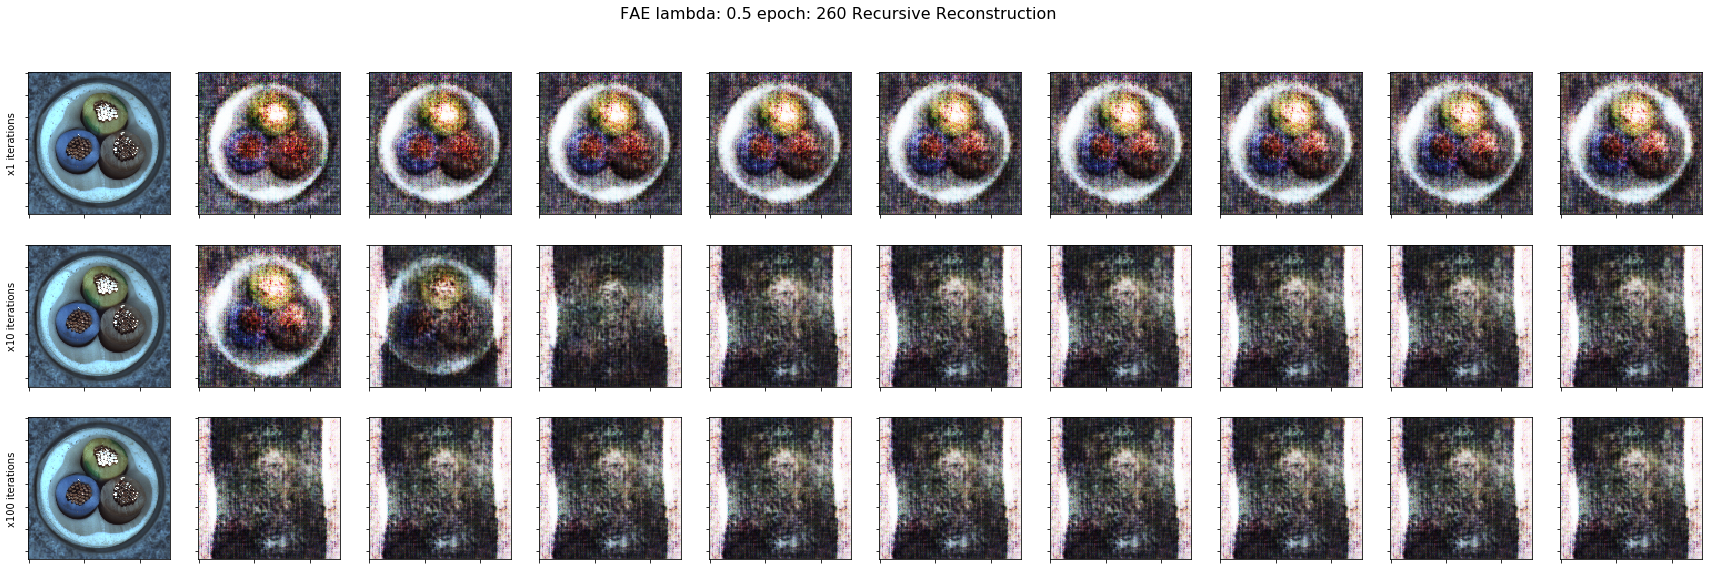

In [61]:
show_img_grid(imgs,
    title="FAE lambda: 0.5 epoch: 260 Recursive Reconstruction",
    #xlabels=['original','reconstruction'],
    ylabels=['x1 iterations','x10 iterations','x100 iterations'])